In [21]:
import sys
sys.path.append('../../')
import h5py
import pandas as pd
import numpy as np
import seaborn as sns

from clips_training.src.utils.visualizer import ClipsVisualizer

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 환경 설정 완료 (경고 숨김 + 한글 폰트)")

✅ 환경 설정 완료 (경고 숨김 + 한글 폰트)


In [2]:
# 📊 직접 HDF5 데이터 로드
print("📊 dataset.h5에서 직접 데이터 로드 중...")

# HDF5 파일 로드
dataset_path = '../../dataset/dataset.h5'
target_config = 1  # config1 = 112차원

with h5py.File(dataset_path, 'r') as f:
    # 기본 정보 확인
    current_size = f.attrs['current_size']
    print(f"   전체 샘플 수: {current_size}")
    
    # 데이터 로드
    X = f[f'features_config_{target_config}'][:current_size]
    y = f['labels'][:current_size] 
    
    # 클립 ID 로드 (문자열 처리)
    clip_ids_raw = f['clip_ids'][:current_size]
    clip_ids = []
    for clip_id in clip_ids_raw:
        if isinstance(clip_id, bytes):
            clip_ids.append(clip_id.decode('utf-8'))
        else:
            clip_ids.append(str(clip_id))
    
    # 메타데이터
    dataset_name = f.attrs.get('dataset_name', 'Unknown')
    created_at = f.attrs.get('created_at', 'Unknown')
    version = f.attrs.get('version', 'Unknown')

print(f"✅ 데이터 로드 완료!")
print(f"   데이터 형태: {X.shape}")
print(f"   라벨 수: {len(y)}")
print(f"   클립 ID 수: {len(clip_ids)}")
print(f"   데이터셋: {dataset_name} (v{version})")

📊 dataset.h5에서 직접 데이터 로드 중...
   전체 샘플 수: 100
✅ 데이터 로드 완료!
   데이터 형태: (100, 112)
   라벨 수: 100
   클립 ID 수: 100
   데이터셋: chimchakman_funny_v1 (v2.0)


In [3]:
# 📋 특징명 생성 (28차원 × 4구간 = 112차원)
def create_feature_names(target_config=1):
    """특징명 생성"""
    # 28차원 기본 특징 정의
    base_features = []
    
    # 감정 특징 (20차원: 평균 10 + 표준편차 10)
    emotions = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 
               'neutral', 'sadness', 'surprise', 'valence', 'arousal']
    for emotion in emotions:
        base_features.append(f'emotion_{emotion}_mean')
    for emotion in emotions:
        base_features.append(f'emotion_{emotion}_std')
    
    # 오디오 특징 (4차원: VAD 필터링)
    base_features.extend([
        'voice_rms_mean',       # 발화 평균 음량
        'voice_rms_max',        # 발화 최대 음량 (핵심!)
        'background_rms_mean',  # 배경음 평균
        'total_rms_std'         # 전체 변동성
    ])
    
    # VAD 특징 (1차원)
    base_features.append('vad_ratio')
    
    # 텐션 특징 (3차원)
    base_features.extend(['tension_mean', 'tension_std', 'tension_max'])
    
    # 구간별 특징명 생성
    segments = 4 if target_config == 1 else (3 if target_config == 2 else 2)
    feature_names = []
    
    for seg in range(1, segments + 1):
        for feat in base_features:
            feature_names.append(f'segment{seg}_{feat}')
    
    return feature_names

# 특징명 생성
feature_names = create_feature_names(target_config)
print(f"📋 특징명 생성 완료: {len(feature_names)}개")

📋 특징명 생성 완료: 112개


In [4]:
# 📊 DataFrame 생성 (분석 편의성)
print("📊 DataFrame 생성 중...")

# 기본 DataFrame 생성
df = pd.DataFrame(X, columns=feature_names)

# 라벨 및 메타데이터 추가
df['label'] = y
df['label_name'] = df['label'].map({0: 'boring', 1: 'funny'})
df['clip_id'] = clip_ids
df['sample_index'] = range(len(df))

print(f"✅ DataFrame 생성 완료: {df.shape}")
print(f"   컬럼 수: {len(df.columns)}")
print(f"   클래스 분포: {df['label_name'].value_counts().to_dict()}")

📊 DataFrame 생성 중...
✅ DataFrame 생성 완료: (100, 116)
   컬럼 수: 116
   클래스 분포: {'funny': 52, 'boring': 48}


In [5]:
# 시각화 도구 초기화 (한글 폰트 자동 설정)
viz = ClipsVisualizer()

✅ ClipsVisualizer 초기화 완료!
   기본 크기: (12, 8)
   색상 팔레트: 4개
💡 한글 폰트는 노트북에서 직접 설정하세요!
✅ 한글 폰트 설정 완료


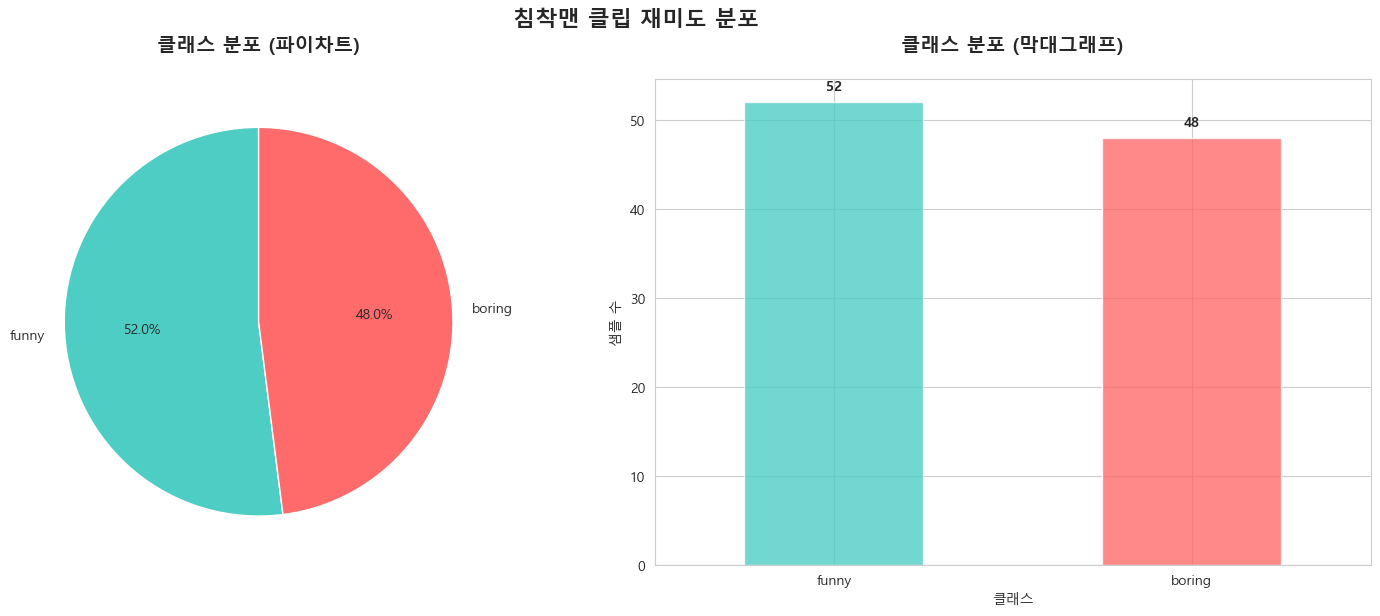

In [8]:
# 1. 클래스 분포 시각화
viz.plot_class_distribution(df)

In [16]:
# 🧩 핵심 특징 그룹 정의 (직접 정의)
def get_key_feature_groups():
    """핵심 특징 그룹 반환"""
    key_features = {
        'audio_critical': [
            'voice_rms_max',         # 발화 최대값 (재미 순간!)
            'background_rms_mean',   # 배경음 (웃음+효과음)  
            'total_rms_std'          # 음량 변동성
        ],
        'emotion_critical': [
            'arousal_mean',          # 흥분도 평균
            'happiness_mean',        # 행복 평균
            'anger_mean',            # 화남 평균
            'arousal_std'            # 흥분도 변동성
        ],
        'tension_critical': [
            'tension_max',           # 텐션 피크
            'tension_mean',          # 평균 텐션
            'tension_std'            # 텐션 변동성
        ],
        'vad_critical': [
            'vad_ratio'              # 발화 비율
        ]
    }
    
    # 실제 특징명으로 확장 (모든 구간)
    expanded_features = {}
    for group_name, patterns in key_features.items():
        expanded_features[group_name] = []
        for pattern in patterns:
            # 각 구간별로 특징 찾기
            matching_features = [f for f in feature_names if pattern in f]
            expanded_features[group_name].extend(matching_features)
    
    return expanded_features

def get_feature_groups():
    """전체 특징 그룹 반환 (블록별)"""
    segments = 4  # config1 = 4구간
    block_size = 28  # 구간별 특징 수
    
    feature_groups = {}
    
    # 구간별 블록
    for seg in range(segments):
        seg_start = seg * block_size
        feature_groups[f'segment{seg+1}_emotion'] = feature_names[seg_start:seg_start + 20]
        feature_groups[f'segment{seg+1}_audio'] = feature_names[seg_start + 20:seg_start + 24]
        feature_groups[f'segment{seg+1}_vad'] = feature_names[seg_start + 24:seg_start + 25]
        feature_groups[f'segment{seg+1}_tension'] = feature_names[seg_start + 25:seg_start + 28]
    
    # 전체 블록별 (구간 통합)
    feature_groups['all_emotion'] = []
    feature_groups['all_audio'] = []
    feature_groups['all_vad'] = []
    feature_groups['all_tension'] = []
    
    for seg in range(segments):
        seg_start = seg * block_size
        feature_groups['all_emotion'].extend(feature_names[seg_start:seg_start + 20])
        feature_groups['all_audio'].extend(feature_names[seg_start + 20:seg_start + 24])
        feature_groups['all_vad'].extend(feature_names[seg_start + 24:seg_start + 25])
        feature_groups['all_tension'].extend(feature_names[seg_start + 25:seg_start + 28])
    
    return feature_groups

# 특징 그룹 생성
key_features = get_key_feature_groups()
feature_groups = get_feature_groups()

print("🧩 핵심 특징 그룹:")
print("=" * 50)
for group_name, features in key_features.items():
    print(f"{group_name}: {len(features)}개")
    for feature in features[:3]:  # 처음 3개만 출력
        print(f"   - {feature}")
    if len(features) > 3:
        print(f"   ... 외 {len(features)-3}개")

print(f"\n📊 전체 특징 블록:")
for group_name, features in feature_groups.items():
    if group_name.startswith('all_'):
        print(f"{group_name}: {len(features)}개 특징")


🧩 핵심 특징 그룹:
audio_critical: 12개
   - segment1_voice_rms_max
   - segment2_voice_rms_max
   - segment3_voice_rms_max
   ... 외 9개
emotion_critical: 16개
   - segment1_emotion_arousal_mean
   - segment2_emotion_arousal_mean
   - segment3_emotion_arousal_mean
   ... 외 13개
tension_critical: 12개
   - segment1_tension_max
   - segment2_tension_max
   - segment3_tension_max
   ... 외 9개
vad_critical: 4개
   - segment1_vad_ratio
   - segment2_vad_ratio
   - segment3_vad_ratio
   ... 외 1개

📊 전체 특징 블록:
all_emotion: 80개 특징
all_audio: 16개 특징
all_vad: 4개 특징
all_tension: 12개 특징


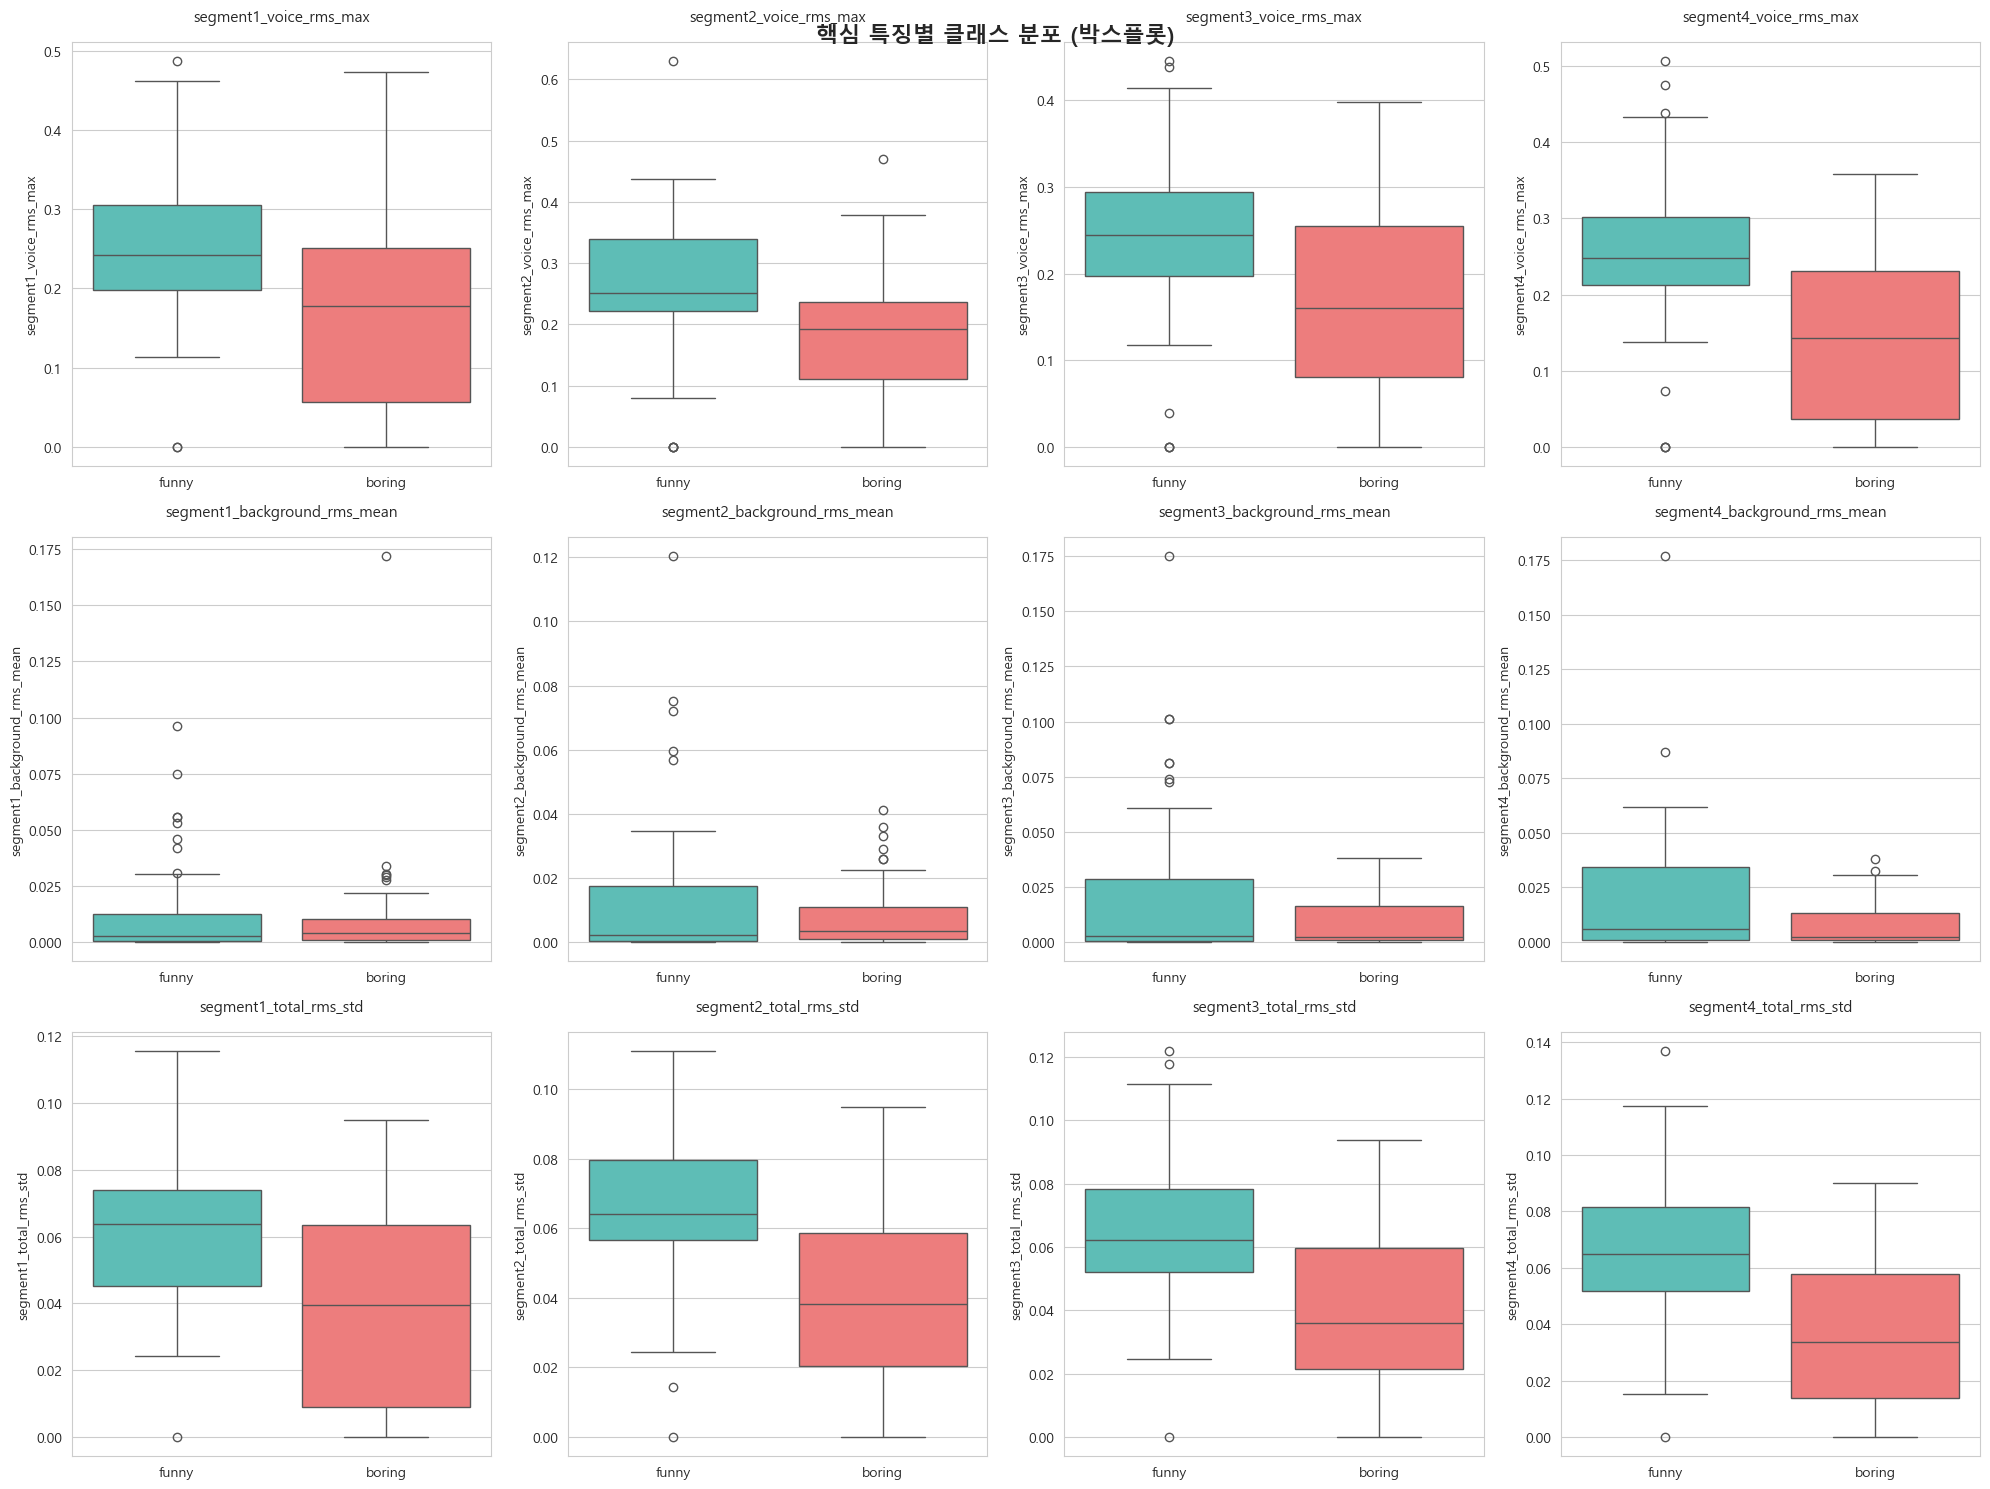

In [17]:
# 2. 핵심 특징 박스플롯
key_feature_names = []
for features in key_features.values():
    key_feature_names.extend(features)

viz.plot_key_features_boxplot(df, key_feature_names)

In [18]:
# 3. 통계 분석
stats_df = viz.statistical_analysis(df, key_feature_names)
viz.print_statistical_results(stats_df)

📊 클래스 간 차이 통계 검증 결과 (p-value 순)
특징명                            Boring평균   Funny평균    차이       p-value    Cohen's d  유의
--------------------------------------------------------------------------------
segment4_tension_max           5.018      8.403      3.384    0.000      1.734      ✅
segment4_emotion_arousal_std   0.045      0.124      0.080    0.000      1.437      ✅
segment4_tension_std           0.735      1.456      0.722    0.000      1.326      ✅
segment4_tension_mean          3.638      5.423      1.786    0.000      1.274      ✅
segment4_emotion_happiness_mean 0.497      2.166      1.670    0.000      1.269      ✅
segment4_total_rms_std         0.036      0.067      0.032    0.000      1.223      ✅
segment3_tension_max           5.327      7.871      2.543    0.000      1.212      ✅
segment3_tension_mean          3.585      5.267      1.682    0.000      1.113      ✅
segment2_total_rms_std         0.040      0.067      0.027    0.000      1.113      ✅
segment3_total_rms_std   

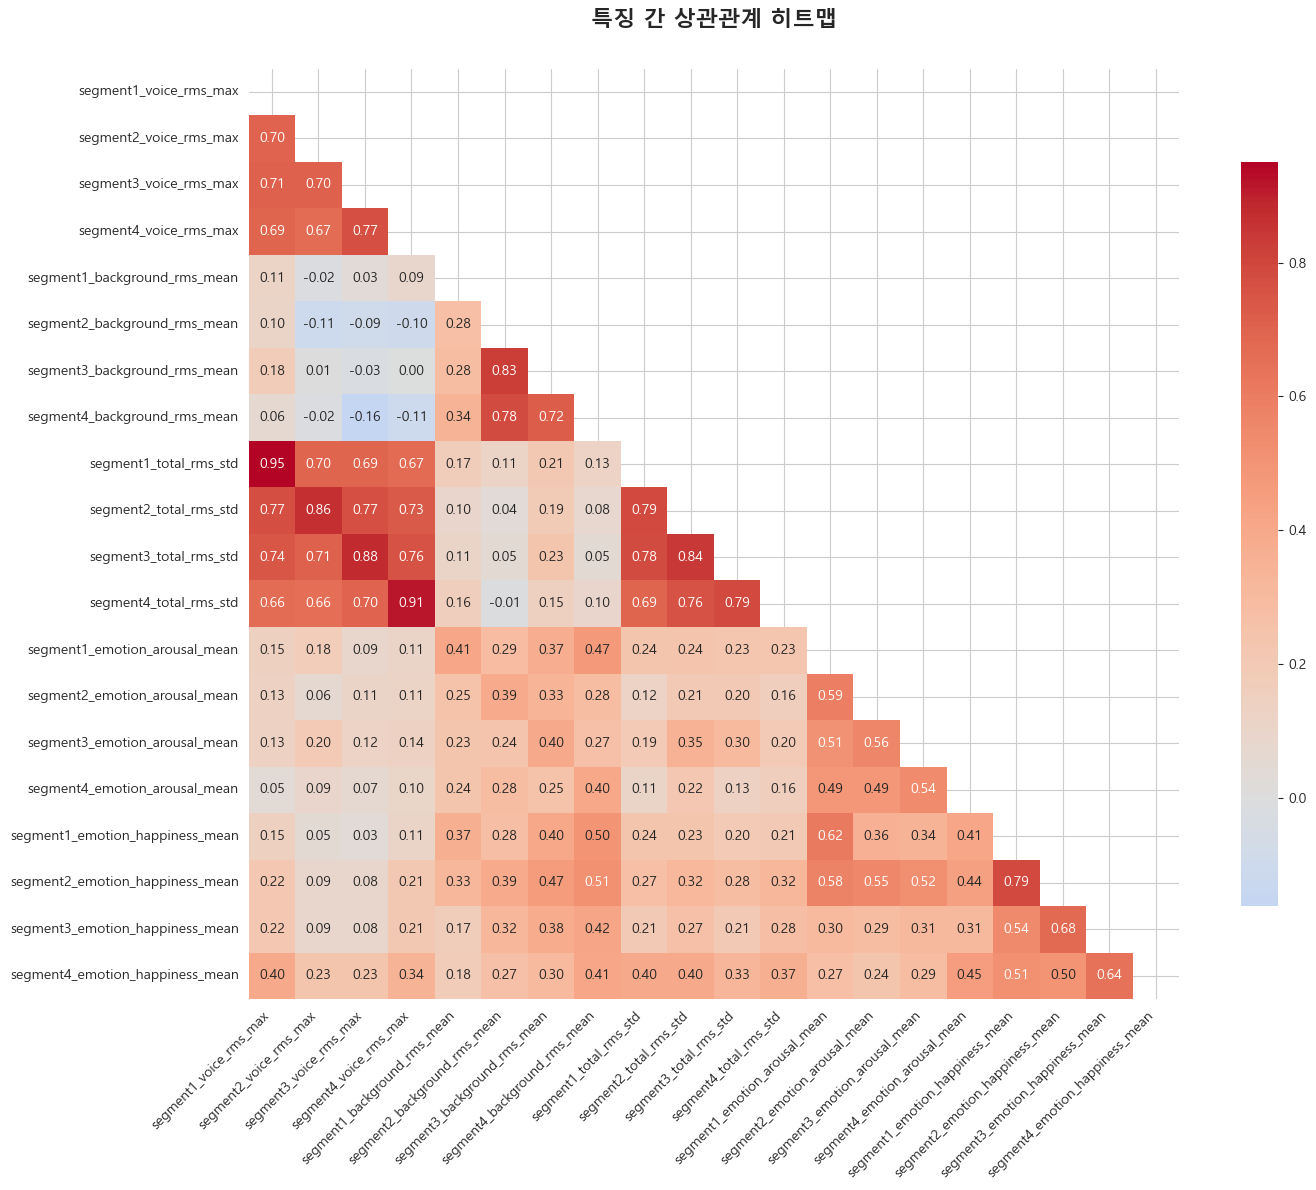

In [19]:
# 4. 상관관계 히트맵 (상위 20개 특징)
correlation_features = key_feature_names[:20]
corr_matrix = viz.plot_correlation_heatmap(df, correlation_features)

📊 상관관계 분석 특징 수: 19


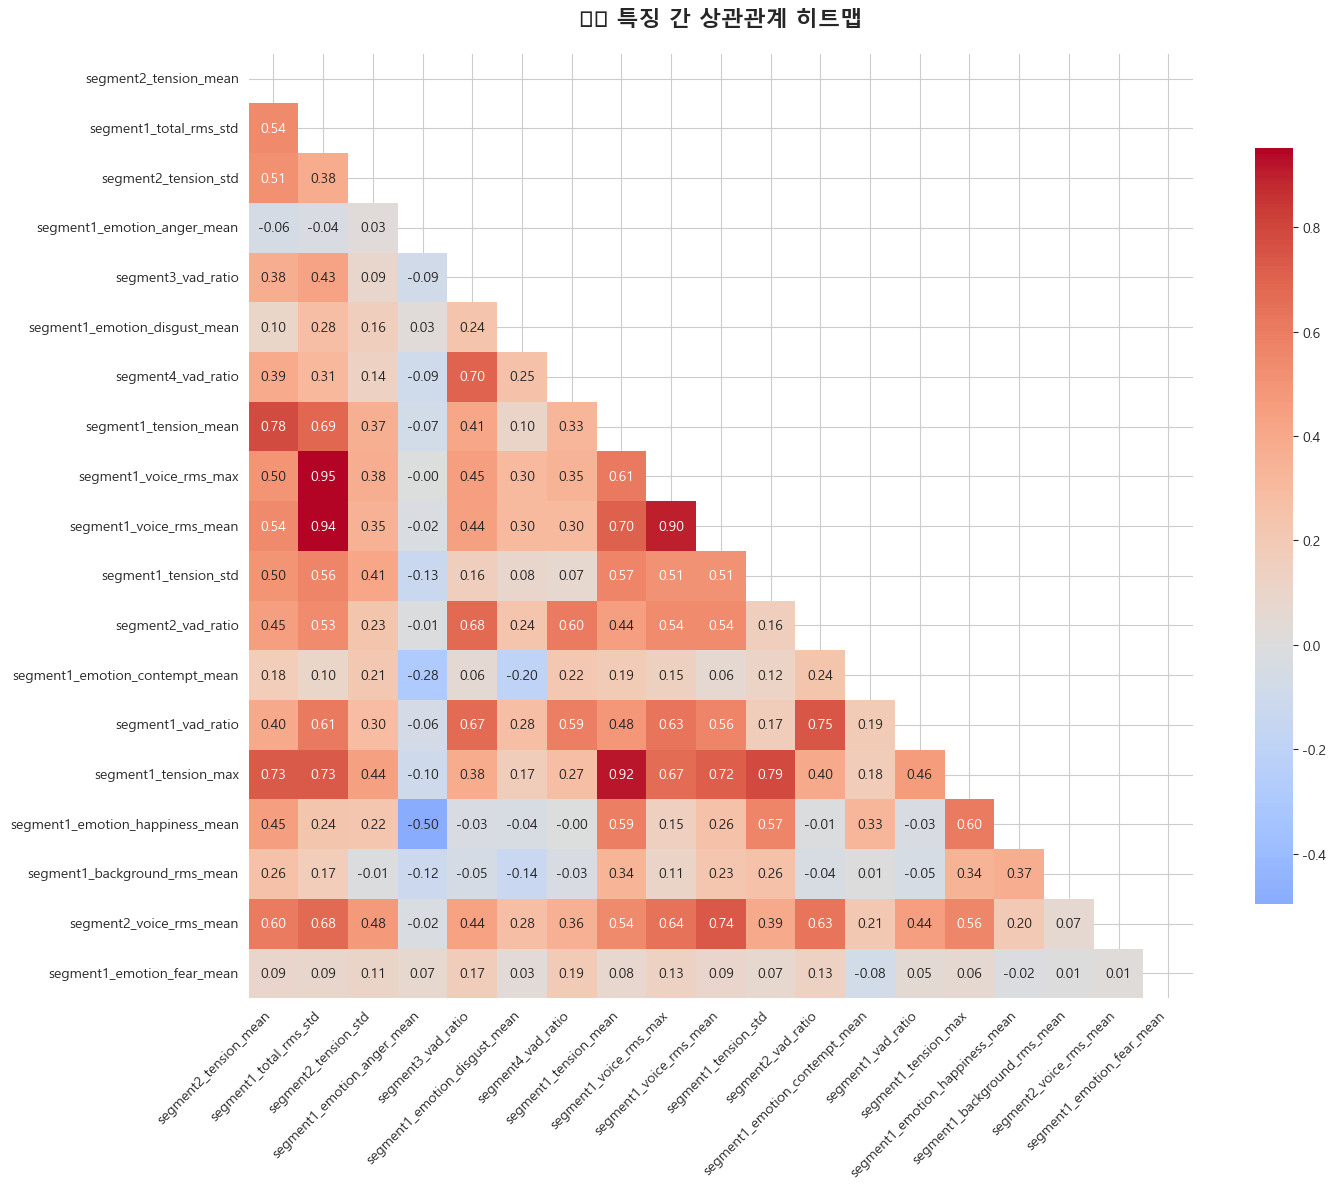


🔥 높은 상관관계 (|r| > 0.7) 특징 쌍:
   segment2_tension_mean ↔ segment1_tension_mean: 0.781
   segment2_tension_mean ↔ segment1_tension_max: 0.731
   segment1_total_rms_std ↔ segment1_voice_rms_max: 0.951
   segment1_total_rms_std ↔ segment1_voice_rms_mean: 0.941
   segment1_total_rms_std ↔ segment1_tension_max: 0.731
   segment3_vad_ratio ↔ segment4_vad_ratio: 0.702
   segment1_tension_mean ↔ segment1_voice_rms_mean: 0.704
   segment1_tension_mean ↔ segment1_tension_max: 0.915
   segment1_voice_rms_max ↔ segment1_voice_rms_mean: 0.898
   segment1_voice_rms_mean ↔ segment1_tension_max: 0.717
   segment1_voice_rms_mean ↔ segment2_voice_rms_mean: 0.739
   segment1_tension_std ↔ segment1_tension_max: 0.790
   segment2_vad_ratio ↔ segment1_vad_ratio: 0.747


In [22]:
# 블록별 상관관계 히트맵
correlation_features = []

# 각 블록에서 대표 특징들만 선택 (너무 많으면 보기 어려우므로)
for group_name, features in feature_groups.items():
    if group_name.startswith('all_'):
        # 각 블록에서 처음 5개 특징만 선택
        selected = [f for f in features[:5] if f in df.columns]
        correlation_features.extend(selected)

# 중복 제거 및 실제 존재하는 특징만 선택
correlation_features = list(set(correlation_features))
correlation_features = [f for f in correlation_features if f in df.columns]

print(f"📊 상관관계 분석 특징 수: {len(correlation_features)}")

if len(correlation_features) > 0:
    # 상관관계 계산
    corr_matrix = df[correlation_features].corr()
    
    # 히트맵 그리기
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각 마스크
    
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'shrink': 0.8})
    
    plt.title('🌡️ 특징 간 상관관계 히트맵', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 높은 상관관계 (|r| > 0.7) 특징 쌍 찾기
    high_corr_pairs = []
    for i in range(len(correlation_features)):
        for j in range(i+1, len(correlation_features)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append({
                    'feature1': correlation_features[i],
                    'feature2': correlation_features[j],
                    'correlation': corr_val
                })
    
    if high_corr_pairs:
        print(f"\n🔥 높은 상관관계 (|r| > 0.7) 특징 쌍:")
        for pair in high_corr_pairs:
            print(f"   {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")
    else:
        print(f"\n✅ 높은 상관관계 (|r| > 0.7) 특징 쌍 없음 (다중공선성 위험 낮음)")


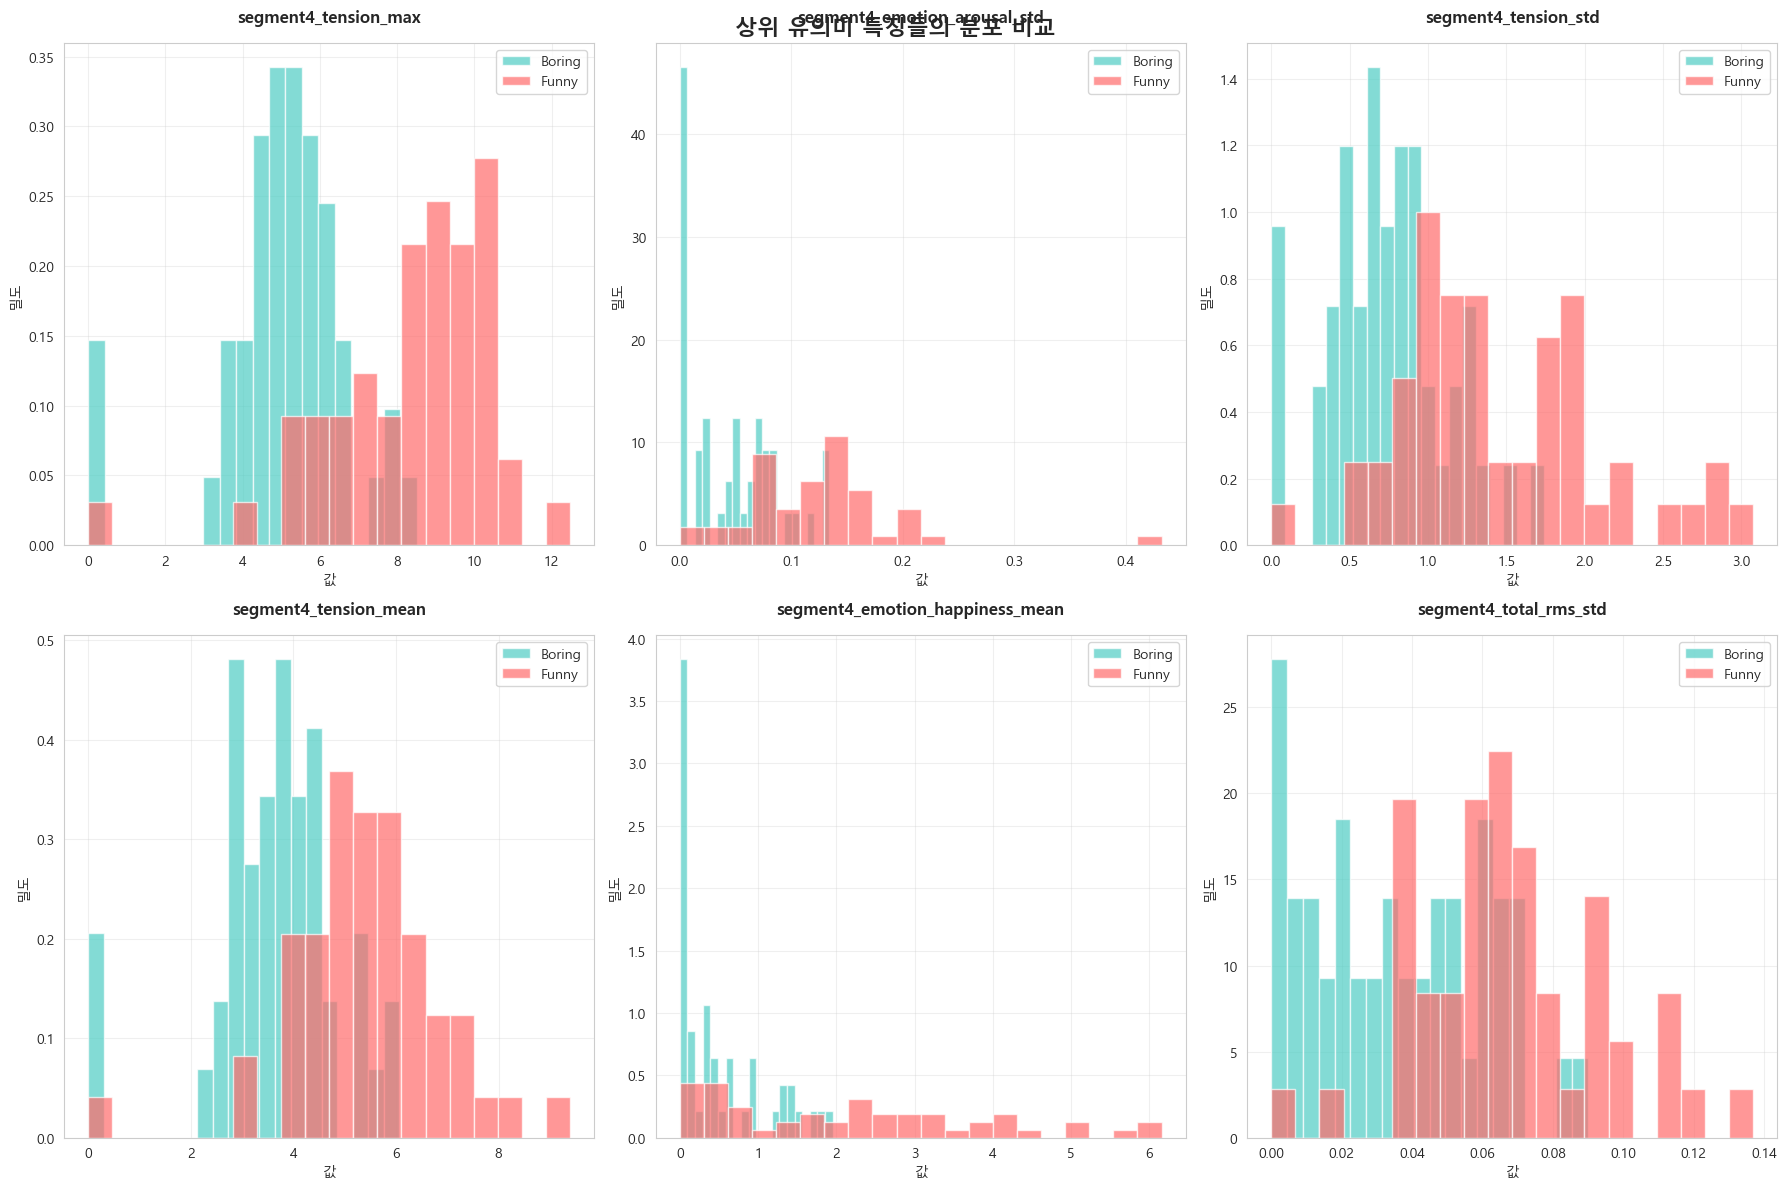

In [23]:
# 5. 분포 비교 (상위 유의미 특징)
top_features = stats_df.head(6)['feature'].tolist()
viz.plot_distribution_comparison(df, top_features)

In [24]:
# 6. 인사이트 요약
high_corr_pairs = viz.find_high_correlations(corr_matrix)
insights = viz.generate_insights_summary(df, stats_df, high_corr_pairs)
viz.print_insights_summary(insights, stats_df)

🎯 EDA 핵심 인사이트 요약
1️⃣ 데이터 균형성: 균형잡힌 (Funny: 52.0%)
2️⃣ 통계적 유의미한 특징: 41/44 (93.2%)
3️⃣ 가장 차별적인 특징 Top 3:
   1. segment4_tension_max: p=0.000, d=1.73 (Funny > Boring)
   2. segment4_emotion_arousal_std: p=0.000, d=1.44 (Funny > Boring)
   3. segment4_tension_std: p=0.000, d=1.33 (Funny > Boring)
4️⃣ 다중공선성 위험: 주의 (13개 쌍)
5️⃣ 데이터 품질: 좋음

💡 학습 모델 권장사항:
   - XGBoost/RandomForest 등 트리 기반 모델 적합
   - 특징 선택 필요성: 낮음
   - 클래스 가중치 조정: 불필요
